# Ch.05 業務要件と処理パターン

## 5.4 オススメ商品の提案（アソシエーション分析）

- オススメ商品の提案
  - 教師なし
  - アソシエーション分析
  - アプリオリ分析

In [34]:
# 共通事前処理

# 余分なワーニングを非表示にする
from IPython.display import display
import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 必要ライブラリのimport

# matplotlib日本語化対応

# データフレーム表示用関数

# 表示オプション調整
# numpyの浮動小数点の表示精度
np.set_printoptions(suppress=True, precision=4)

# pandasでの浮動小数点の表示精度
pd.options.display.float_format = '{:.4f}'.format

# データフレームですべての項目を表示
pd.set_option("display.max_columns", None)

# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14

# 乱数の種
RANDOM_SEED = 123

### 5.4.1 処理パターンと想定される業務利用シーン

- 得られた知見をもとに、何か戦略を考え、その硬貨があって初めて分析の意味を持つ
- 教師あり学習
  - 正解データの収集が大変だが、モデル構築までできれば業務での活用は比較的カンタンなことが多い
- 教師なしデータ
  - 正解データの収集は不要なので、モデルの構築は比較的カンタン
  - 業務の活用では、「知見をもとに戦略を考え、効果を出す」
  - 1工程多い分、比較的難易度が高い

### 5.4.2 例題のデータ説明とユースケース

- Online Retail Data Set（オンライン小売データセット）
  - <http://archive.ics.uci.edu/ml/datasets/Online+Retail/>
- データ項目メモ
  - InvoiceNo: 発注番号
  - StockCode: 商品番号
  - Description: 商品説明
  - Quantity: 商品個数
  - InvoiceDate: 明細書発行日
  - UnitPrice: 商品単価
  - CustomerID: 顧客番号
  - Country: 国名

### 5.4.3 モデルの概要

- アソシエーション分析
  - 支持度（support）
    - 顧客全体の中で、いま注目している商品を購入した顧客の比率
    - S(商品A) = 4/10 =0.4
    - S(商品B) = 5/10 =0.5
    - S(商品A AND 商品B) = 3/10 =0.3
  - 確信度（confidence）
    - S(商品A AND 商品B) / S(商品A)= 0.3/0.4 =0.75
    - 「AならばB」の確信度
    - Aを買った人のうちBも一緒に買った人
  - リフト値（lift）
    - S(商品A AND 商品B) / (S(商品A)*S(商品B))= 0.3/(0.4*0.5) =1.5
    - 「AならばB」、「BならばA」
    - 「商品Aを買う事象」と「商品Bを買う事象」が「独立な事象」ならば、リフト値は「1」になる
    - なんらかの因果関係（相関）があると、リフト値は「1」より大きくなる
  - ルール
    - 2つの商品または商品グループ間の関係
  - アプリオリ分析

### 5.4.4 データ読み込みからデータ確認まで

データ読み込み

In [35]:
# データ読み込み
# 公開データはExcel形式なので、read_excel関数で直接読み込む
# 時間がかなりかかるので注意してください (ファイルサイズ 約23MB)
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'
df = pd.read_excel(url)

# 項目名を日本語に変更
columns = [
    '発注番号', '商品番号', '商品説明', '商品個数', '明細書発行日',
    '商品単価', '顧客番号', '国名'
]
df.columns = columns

データ確認

In [36]:
# データ数確認
# print(df.shape[0])
print(df.shape)

# データ内容確認
display(df.head())

(541909, 8)


,発注番号,商品番号,商品説明,商品個数,明細書発行日,商品単価,顧客番号,国名
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.5500,17850.0000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.7500,17850.0000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom


In [37]:
# 欠損値確認
print(df.isnull().sum())

発注番号           0
商品番号           0
商品説明        1454
商品個数           0
明細書発行日         0
商品単価           0
顧客番号      135080
国名             0
dtype: int64


In [38]:
# 国名確認
print(df['国名'].value_counts().head(10))

United Kingdom    495478
Germany             9495
France              8557
EIRE                8196
Spain               2533
Netherlands         2371
Belgium             2069
Switzerland         2002
Portugal            1519
Australia           1259
Name: 国名, dtype: int64


### 5.4.5 データ前処理

- 方針:
  - 発注番号の最初の1文字を抽出、「発注種別」列を作る
  - 「発注種別」を基に新規オーダーのみを抽出
  - 対象国をフランスに限定
  - データをone hot形式(商品ごとに列を持つ形)に変換

対象を新規オーダーだけに限定

In [39]:
# 「発注種別」列の追加

# 前処理用にデータをコピー
df2 = df.copy()

# 発注番号の頭1桁を別項目に抽出
# (5: 新規オーダー  C:キャンセル)
df2['発注種別'] = df2['発注番号'].map(lambda x: str(x)[0])

# 結果確認
display(df2.head())

# 種別個数確認
print(df2['発注種別'].value_counts())

,発注番号,商品番号,商品説明,商品個数,明細書発行日,商品単価,顧客番号,国名,発注種別
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.5500,17850.0000,United Kingdom,5
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom,5
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.7500,17850.0000,United Kingdom,5
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom,5
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom,5


5    532618
C      9288
A         3
Name: 発注種別, dtype: int64


In [40]:
#  新規オーダーのみ抽出
df2 = df2[df2['発注種別'] == '5']

# 件数確認
print(df2.shape[0])

532618


対象をフランスに限定

In [41]:
# 分析対象をフランスに限定する
df3 = df2[df2['国名'] == 'France']

# 件数確認
print(df3.shape[0])

8408


データをOne-Hot形式化

In [42]:
# 発注番号と商品番号をキーに商品個数を集計する
w1 = df3.groupby(['発注番号', '商品番号'])['商品個数'].sum()

# 結果確認
print(w1.head())
print(w1.tail())

発注番号    商品番号 
536370  10002    48
        21035    18
        21724    12
        21731    24
        21791    24
Name: 商品個数, dtype: int64
発注番号    商品番号 
581587  22730    4
        22899    6
        23254    4
        23255    4
        23256    4
Name: 商品個数, dtype: int64


In [43]:
# 商品番号を列に移動 (unstack関数の利用)
# w2 = w1.unstack().reset_index().fillna(0).set_index('発注番号')
w2 = w1.unstack().fillna(0)

# サイズ確認
print(w2.shape)

# 結果確認
display(w2.head())

(392, 1542)


商品番号     10002  10120  10125  10135  11001  15036  15039  16012  16048  16218  \
発注番号                                                                            
536370 48.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
536852  0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
536974  0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
537065  0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
537463  0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   

商品番号    16219  16225  16236  16237   16238  17174  20615  20617  20658  20665  \
発注番号                                                                            
536370 0.0000 0.0000 0.0000 0.0000  0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
536852 0.0000 0.0000 0.0000 0.0000  0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
536974 0.0000 0.0000 0.0000 0.0000  0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
537065 0.0000 0.0000 0.0000 0.0000 28.0000 0.0000 0.0000 0.0000 0.0000 6.0000   
537463 0.0000 0.0000 0.0000 0.0000  0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   

商品番号    20668  20674  20675  20676  20677  20679  20681  20682  20684  20685  \
発注番号                                                                           
536370 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
536852 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
536974 0.0000 0.0000 0.0000 0.0000 0.0000 6.0000 0.0000 0.0000 0.0000 0.0000   
537065 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
537463 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 6.0000 6.0000 0.0000 0.0000   

商品番号    20686  20702  20704  20711  20712  20713  20717  20718   20719  20723  \
発注番号                                                                            
536370 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000  0.0000 0.0000   
536852 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000  0.0000 0.0000   
536974 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000  0.0000 0.0000   
537065 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000  0.0000 0.0000   
537463 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 10.0000 0.0000   

商品番号    20724   20725   20726  20727   20728  20749  20750  20751  20767  \
発注番号                                                                       
536370 0.0000  0.0000  0.0000 0.0000  0.0000 0.0000 0.0000 0.0000 0.0000   
536852 0.0000  0.0000  0.0000 0.0000  0.0000 0.0000 0.0000 0.0000 0.0000   
536974 0.0000 10.0000 10.0000 0.0000  0.0000 2.0000 2.0000 0.0000 0.0000   
537065 0.0000 10.0000 20.0000 0.0000 10.0000 2.0000 6.0000 0.0000 0.0000   
537463 0.0000  0.0000  0.0000 0.0000  0.0000 0.0000 0.0000 0.0000 0.0000   

商品番号    20777  20819  20832  20866  20914  20961  20963  20966  20967  20971  \
発注番号                                                                           
536370 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
536852 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
536974 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
537065 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
537463 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   

商品番号    20972  20973  20974  20975  20977  20978  20979  20981  20983  20984  \
発注番号                                                                           
536370 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
536852 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
536974 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
537065 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   
537463 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000   

商品番号    20992  20996  21003  21012  21026  21027  21030  21034   21035  21039  \

In [44]:
# 集計結果が正か0かでTrue/Falseを設定
basket_df = w2.apply(lambda x: x > 0)

# 結果確認
display(basket_df.head())

商品番号    10002  10120  10125  10135  11001  15036  15039  16012  16048  16218  \
発注番号                                                                           
536370   True  False  False  False  False  False  False  False  False  False   
536852  False  False  False  False  False  False  False  False  False  False   
536974  False  False  False  False  False  False  False  False  False  False   
537065  False  False  False  False  False  False  False  False  False  False   
537463  False  False  False  False  False  False  False  False  False  False   

商品番号    16219  16225  16236  16237  16238  17174  20615  20617  20658  20665  \
発注番号                                                                           
536370  False  False  False  False  False  False  False  False  False  False   
536852  False  False  False  False  False  False  False  False  False  False   
536974  False  False  False  False  False  False  False  False  False  False   
537065  False  False  False  False   True  False  False  False  False   True   
537463  False  False  False  False  False  False  False  False  False  False   

商品番号    20668  20674  20675  20676  20677  20679  20681  20682  20684  20685  \
発注番号                                                                           
536370  False  False  False  False  False  False  False  False  False  False   
536852  False  False  False  False  False  False  False  False  False  False   
536974  False  False  False  False  False   True  False  False  False  False   
537065  False  False  False  False  False  False  False  False  False  False   
537463  False  False  False  False  False  False   True   True  False  False   

商品番号    20686  20702  20704  20711  20712  20713  20717  20718  20719  20723  \
発注番号                                                                           
536370  False  False  False  False  False  False  False  False  False  False   
536852  False  False  False  False  False  False  False  False  False  False   
536974  False  False  False  False  False  False  False  False  False  False   
537065  False  False  False  False  False  False  False  False  False  False   
537463  False  False  False  False  False  False  False  False   True  False   

商品番号    20724  20725  20726  20727  20728  20749  20750  20751  20767  20777  \
発注番号                                                                           
536370  False  False  False  False  False  False  False  False  False  False   
536852  False  False  False  False  False  False  False  False  False  False   
536974  False   True   True  False  False   True   True  False  False  False   
537065  False   True   True  False   True   True   True  False  False  False   
537463  False  False  False  False  False  False  False  False  False  False   

商品番号    20819  20832  20866  20914  20961  20963  20966  20967  20971  20972  \
発注番号                                                                           
536370  False  False  False  False  False  False  False  False  False  False   
536852  False  False  False  False  False  False  False  False  False  False   
536974  False  False  False  False  False  False  False  False  False  False   
537065  False  False  False  False  False  False  False  False  False  False   
537463  False  False  False  False  False  False  False  False  False  False   

商品番号    20973  20974  20975  20977  20978  20979  20981  20983  20984  20992  \
発注番号                                                                           
536370  False  False  False  False  False  False  False  False  False  False   
536852  False  False  False  False  False  False  False  False  False  False   
536974  False  False  False  False  False  False  False  False  False  False   
537065  False  False  False  False  False  False  False  False  False  False   
537463  False  False  False  False  False  False  False  False  False  False   

商品番号    20996  21003  21012  21026  21027  21030  21034  21035  21039  21

### コラム 商品名辞書の作成

- <https://github.com/makaishi2/profitable_ai_book_info/blob/master/docs/C2-%E5%AE%9F%E7%BF%92%E3%82%B3%E3%83%BC%E3%83%87%E3%82%A3%E3%83%B3%E3%82%B0%E8%A3%9C%E8%B6%B3%E8%A7%A3%E8%AA%AC.md>

「商品番号」と「商品説明」の対応表の作成

コードC2-1-1 元データから「商品番号」と「商品説明」を抽出

In [45]:
# 「商品番号」と「商品説明」のみを抽出
# drop_duplicates()関数: 重複を取り除く
w3 = df2[['商品番号', '商品説明']].drop_duplicates()

# 商品番号と商品名をすべて文字列に変換
w3['商品番号'] = w3['商品番号'].astype('str')
w3['商品説明'] = w3['商品説明'].astype('str')

# 商品番号をインデックスに
w3 = w3.set_index('商品番号')
display(w3.head())

,商品説明
商品番号,
85123A,WHITE HANGING HEART T-LIGHT HOLDER
71053,WHITE METAL LANTERN
84406B,CREAM CUPID HEARTS COAT HANGER
84029G,KNITTED UNION FLAG HOT WATER BOTTLE
84029E,RED WOOLLY HOTTIE WHITE HEART.


コードC2-1-2 五つの商品コードで検索をした結果

In [46]:
# 冒頭の5個の商品コード抽出
item_list1 = w3.index[:5]

# w3に対する検索結果
display(w3.loc[item_list1])

,商品説明
商品番号,
85123A,WHITE HANGING HEART T-LIGHT HOLDER
85123A,?
85123A,wrongly marked carton 22804
85123A,CREAM HANGING HEART T-LIGHT HOLDER
71053,WHITE METAL LANTERN
71053,WHITE MOROCCAN METAL LANTERN
84406B,CREAM CUPID HEARTS COAT HANGER
84406B,incorrectly made-thrown away.
84406B,?


コードC2-1-3 大文字だけのテキスト抽出

In [47]:
# 大文字だけのテキストの抽出

# 作業用にコピー
w4 = w3.copy()

# すべて大文字名称の行のみ残す
w4 = w4[w4['商品説明'].map(lambda x: x.isupper())]

# 先ほど作ったitem_list1で結果確認
display(w4.loc[item_list1])

,商品説明
商品番号,
85123A,WHITE HANGING HEART T-LIGHT HOLDER
85123A,CREAM HANGING HEART T-LIGHT HOLDER
71053,WHITE METAL LANTERN
71053,WHITE MOROCCAN METAL LANTERN
84406B,CREAM CUPID HEARTS COAT HANGER
84029G,KNITTED UNION FLAG HOT WATER BOTTLE
84029E,RED WOOLLY HOTTIE WHITE HEART.


コードC2-1-4 一番長い名称の抽出

In [48]:
# 一番長い名称の抽出

# 作業用にコピー
w5 = w4.copy()

# 「文字数」列の追加
w5['文字数'] = w5['商品説明'].map(len)

# ソート
w5 = w5.sort_values(['商品番号', '文字数'], ascending=[True, False])

# 商品番号ごとに一番長い名称を抽出してitem_dictに代入
item_dict = w5.groupby('商品番号')['商品説明'].agg(lambda x: x[0])

# 先ほど作ったitem_list1で結果確認
display(item_dict.loc[item_list1])

商品番号
85123A     WHITE HANGING HEART T-LIGHT HOLDER
71053            WHITE MOROCCAN METAL LANTERN
84406B         CREAM CUPID HEARTS COAT HANGER
84029G    KNITTED UNION FLAG HOT WATER BOTTLE
84029E         RED WOOLLY HOTTIE WHITE HEART.
Name: 商品説明, dtype: object

### 5.4.6 アルゴリズム選択と分析

mlxtendライブラリから、association_rulesとapprioriを利用する

In [49]:
# ライブラリの読み込み
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [50]:
# アプリオリによる分析
freq_items1 = apriori(
    basket_df, min_support=0.06, use_colnames=True
)

# 結果確認
display(
    freq_items1.sort_values('support', ascending=False).head(10)
)

# itemset数確認
print(freq_items1.shape[0])

,support,itemsets
61,0.7653,(POST)
52,0.1888,(23084)
14,0.1811,(21731)
37,0.1709,(22554)
39,0.1684,(22556)
114,0.1658,"(POST, 23084)"
24,0.1582,(22326)
82,0.1582,"(POST, 21731)"
4,0.1531,(20725)
89,0.1480,"(POST, 22326)"


134


In [51]:
# アソシエーションルールの抽出
a_rules1 = association_rules(
    freq_items1, metric="lift", min_threshold=1
)

# リフト値でソート
a_rules1 = a_rules1.sort_values('lift', ascending=False).reset_index(drop=True)

# 結果確認
display(a_rules1.head(10))

# ルール数確認
print(a_rules1.shape[0])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(23254),(23256),0.0714,0.0689,0.0638,0.8929,12.9630,0.0589,8.6905
1,(23256),(23254),0.0689,0.0714,0.0638,0.9259,12.9630,0.0589,12.5357
2,(22727),"(22728, 22726)",0.0944,0.0740,0.0638,0.6757,9.1333,0.0568,2.8552
3,"(22728, 22726)",(22727),0.0740,0.0944,0.0638,0.8621,9.1333,0.0568,6.5657
4,"(POST, 22726)",(22727),0.0842,0.0944,0.0714,0.8485,8.9894,0.0635,5.9770
5,(22727),"(POST, 22726)",0.0944,0.0842,0.0714,0.7568,8.9894,0.0635,3.7650
6,(22726),"(22728, 22727)",0.0969,0.0740,0.0638,0.6579,8.8929,0.0566,2.7068
7,"(22728, 22727)",(22726),0.0740,0.0969,0.0638,0.8621,8.8929,0.0566,6.5472
8,(22727),(22726),0.0944,0.0969,0.0791,0.8378,8.6430,0.0699,5.5689
9,(22726),(22727),0.0969,0.0944,0.0791,0.8158,8.6430,0.0699,4.9162


206


In [52]:
# 関係性の高い商品の商品コードをリストアップ
item_list = ['23254', '23256', '22726', '22727', '22728']

# 商品名を確認
for item in item_list:
    print(item, item_dict[item])

23254 CHILDRENS CUTLERY DOLLY GIRL 
23256 CHILDRENS CUTLERY SPACEBOY 
22726 ALARM CLOCK BAKELIKE GREEN
22727 ALARM CLOCK BAKELIKE RED 
22728 ALARM CLOCK BAKELIKE PINK


### 5.4.7 チューニング

5.4.6 と同じ分析を、min_supportの値を0.065に変更して試してみる

In [53]:
# アプリオリによる分析
freq_items2 = apriori(
    basket_df, min_support=0.065, use_colnames=True
)

# アソシエーションルールの抽出
a_rules2 = association_rules(freq_items2, metric="lift", min_threshold=1)

# リフト値でソート
a_rules2 = a_rules2.sort_values('lift', ascending=False).reset_index(drop=True)

# 結果確認
display(a_rules2.head(10))

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(22727),"(POST, 22726)",0.0944,0.0842,0.0714,0.7568,8.9894,0.0635,3.7650
1,"(POST, 22726)",(22727),0.0842,0.0944,0.0714,0.8485,8.9894,0.0635,5.9770
2,(22726),(22727),0.0969,0.0944,0.0791,0.8158,8.6430,0.0699,4.9162
3,(22727),(22726),0.0944,0.0969,0.0791,0.8378,8.6430,0.0699,5.5689
4,(22726),"(POST, 22727)",0.0969,0.0867,0.0714,0.7368,8.4954,0.0630,3.4704
5,"(POST, 22727)",(22726),0.0867,0.0969,0.0714,0.8235,8.4954,0.0630,5.1173
6,"(22728, POST)",(22727),0.0893,0.0944,0.0663,0.7429,7.8703,0.0579,3.5218
7,(22727),"(22728, POST)",0.0944,0.0893,0.0663,0.7027,7.8703,0.0579,3.0633
8,(22728),(22727),0.1020,0.0944,0.0740,0.7250,7.6811,0.0643,3.2931
9,(22727),(22728),0.0944,0.1020,0.0740,0.7838,7.6811,0.0643,4.1531


aprioriの2つの結果から、「23254」「23256」に関係している項目を抽出

In [54]:
# 調査対象の集合
t_set = set([23254, 23256])

# 1回目の分析freq_item1から該当行を抽出
idx1 = freq_items1['itemsets'].map(lambda x: not x.isdisjoint(t_set))
item1 = freq_items1[idx1]

# 2回目の分析freq_item2から該当行を抽出
idx2 = freq_items2['itemsets'].map(lambda x: not x.isdisjoint(t_set))
item2 = freq_items2[idx2]

# 結果確認
display(item1)
display(item2)

,support,itemsets
58,0.0714,(23254)
59,0.0689,(23256)
118,0.0638,"(23256, 23254)"


,support,itemsets
53,0.0714,(23254)
54,0.0689,(23256)


### 5.4.8 グラフ表示

商品間の関係を有向グラフ表示する。

<https://github.com/makaishi2/profitable_ai_book_info/blob/master/docs/C2-%E5%AE%9F%E7%BF%92%E3%82%B3%E3%83%BC%E3%83%87%E3%82%A3%E3%83%B3%E3%82%B0%E8%A3%9C%E8%B6%B3%E8%A7%A3%E8%AA%AC.md#C22>

- 「関係ネットワーク」とは、
  - 「ノード」(今回の場合は、商品または商品グループ)と、「エッジ」(ノード間の関係)によって表現されるデータです。

ノードの抽出

- 関係グラフを視覚化するために最初にすることは、関係するノードを一覧の形で抽出すること。

コード C2-2-1 ノードの抽出

In [55]:
# 対象とする関係を上位50に限定
a = a_rules1.head(20)

# 親ノードの抽出
# 前提商品を意味する「antecedents」列
# これらの列の項目はfrozensetと呼ばれる特殊なデータ型なので、タプルに変換
ant = a['antecedents'].values
ant = [tuple(x) for x in ant]

# 子ノードの抽出
# 帰結商品を意味する「consequents」列
# これらの列の項目はfrozensetと呼ばれる特殊なデータ型なので、タプルに変換
con = a['consequents'].values
con = [tuple(x) for x in con]

# 全ノードのリストアップ
# こうやって作ったノード候補（タプル）のリストbothには重複がある。
# list(set(both))は、このリストを一度「集合」に変換し、最後にリストに戻す。
# こうすることで、ユニークなノードのリストができる。
both = ant + con
both = list(set(both))

# 結果の一部確認
print(both[:10])

[(21080, 21086), (22726, 22727), (22728, 22727), (23254,), (21094,), (22727,), ('POST', 22727), (22728, 22726), (22726,), (23256,)]


関係グラフの構築

グラフはPythonの場合、networkxというライブラリを用いる。

コードC2-2-2 関係グラフの構築

In [56]:
# networkx のインポート
import networkx as nx

# 関係グラフの初期化
G = nx.DiGraph()

# ノードの追加
for n in both:
    G.add_node(n)

# エッジの追加
for i in range(len(a)):
    item = a.loc[i]
    ant = tuple(item['antecedents'])
    con = tuple(item['consequents'])
    G.add_edge(ant, con)

コードC2-2-3 関係グラフの視覚化

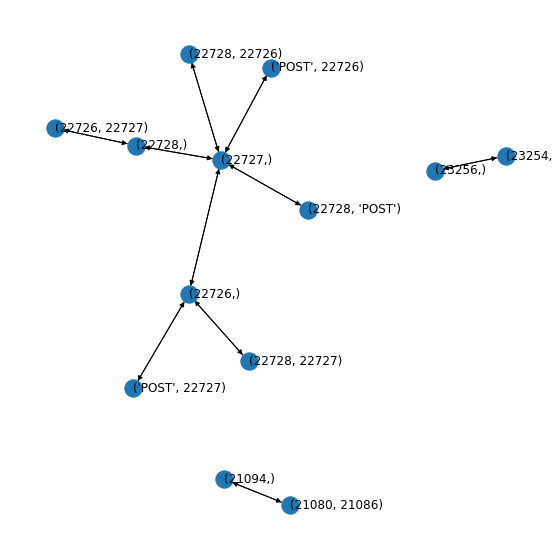

In [57]:
# グラフ描画
pos = nx.spring_layout(G, k=0.6, seed=RANDOM_SEED)

plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(
    G, pos, horizontalalignment='left', verticalalignment='center'
)
plt.axis('off')
plt.tight_layout()
plt.show()